# Risk Attribution: Menchero Methodology ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.stats import norm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from factors_toolkit import FamaFrenchFactors
from portfolios_toolkit import markowitz_weights
from portfolios_toolkit import portfolio_variance

### Building a Portfolio ###

In [2]:
# Import the Returns Data
returns_df = pd.read_csv(r'..\additional_data\stocks_returns.csv')
returns_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
returns_df.set_index('Date', inplace=True)
returns_df.index = pd.to_datetime(returns_df.index)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018915,-0.028576,-0.018998,0.000222,-0.004989,-0.018352,-0.035215,-0.000721,-0.014722,-0.010052,...,-0.013900,0.000000,-0.017166,-0.011416,-0.027743,-0.064259,-0.020527,0.036625,-0.014177,-0.006022
2015-01-06,-0.015700,0.000094,-0.004962,-0.011421,-0.020350,-0.023753,-0.019911,-0.008324,-0.019973,-0.011709,...,-0.017255,-0.001108,-0.021562,0.005306,-0.005330,-0.005898,-0.012351,-0.008513,-0.007231,-0.009804
2015-01-07,0.013184,0.013925,0.039621,0.008076,0.008190,0.010462,0.014920,0.008685,-0.002089,0.007747,...,0.016088,0.003045,0.028945,0.008598,0.010081,0.007857,0.032601,0.024566,0.025146,0.020432
2015-01-08,0.029534,0.037702,0.010404,0.020345,0.025135,0.017501,-0.014717,0.022681,0.024446,0.003522,...,0.019467,0.010722,0.011959,0.011532,0.016508,0.007517,0.017270,0.010561,0.021134,0.015282
2015-01-09,-0.007364,0.001072,-0.027736,-0.010563,-0.014922,-0.000731,-0.008566,-0.007188,-0.009054,-0.011270,...,-0.011519,-0.001368,0.012422,-0.012361,-0.001411,-0.019043,-0.001768,-0.014529,0.014508,0.001583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011083,0.011413,0.008985,0.003929,0.002683,0.014782,0.004355,0.007822,0.012494,0.013291,...,0.009663,0.006390,0.007575,0.007210,0.000940,0.005432,0.008480,0.004484,0.012187,0.002553
2024-12-26,-0.001986,0.003171,-0.004454,0.004434,0.004944,-0.000138,-0.000395,0.002594,-0.003159,-0.002203,...,0.001981,-0.003190,0.005952,-0.000440,0.000845,0.002705,0.007380,-0.000466,0.003559,0.004966
2024-12-27,-0.002137,-0.013331,-0.006663,-0.002432,-0.008208,-0.004919,-0.000593,-0.003539,-0.008999,-0.006305,...,-0.000630,-0.006410,-0.007079,-0.000587,-0.000094,-0.007966,-0.005678,-0.003549,-0.019799,-0.005574


In [3]:
# Make the portfolio DataFrame
portfolio_holdings_df = returns_df[['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'GOOG']]
portfolio_holdings_df = portfolio_holdings_df

portfolio_holdings_df

,AAPL,AMZN,META,MSFT,NVDA,GOOG
Date,,,,,,
2015-01-05,-0.028576,-0.020731,-0.016191,-0.009238,-0.017035,-0.021066
2015-01-06,0.000094,-0.023098,-0.013565,-0.014786,-0.030788,-0.023450
2015-01-07,0.013925,0.010544,0.000000,0.012625,-0.002609,-0.001715
2015-01-08,0.037702,0.006813,0.026309,0.028994,0.036927,0.003148
2015-01-09,0.001072,-0.011818,-0.005644,-0.008441,0.004020,-0.013035
...,...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930,0.008029
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070,-0.002382
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088,-0.015647


In [4]:
# Portfolio's Returns and Variances
expected_returns = portfolio_holdings_df.mean()
covariance_matrix = portfolio_holdings_df.cov()

In [5]:
# Obtain Weights
p_weights = markowitz_weights(
    expected_returns, 
    covariance_matrix,
    0.0015
)

p_weights

array([ 0.2608526 ,  0.23302447, -0.14342388,  0.2254734 ,  0.4015833 ,
        0.0224901 ])

In [6]:
# Create a Portfolio Weights DF
portfolio_weights = pd.Series(
    p_weights,
    index = portfolio_holdings_df.columns,
    name = 'weights'
)

portfolio_weights

AAPL    0.260853
AMZN    0.233024
META   -0.143424
MSFT    0.225473
NVDA    0.401583
GOOG    0.022490
Name: weights, dtype: float64

In [7]:
# Portfolios Variance
p_variance = portfolio_variance(p_weights, portfolio_holdings_df)

p_variance

0.0003936124972502737

In [8]:
# Portfolio Returns
portfolio_returns = portfolio_holdings_df @ p_weights
portfolio_returns.name = 'portfolio_returns'

In [9]:
# Holdings Standard Deviations
holdings_stds = portfolio_holdings_df.std()

holdings_stds

AAPL    0.017931
AMZN    0.020573
META    0.023847
MSFT    0.017091
NVDA    0.030376
GOOG    0.017919
dtype: float64

In [10]:
# Holding's correlations with the portfolio
corr_with_portfolio = portfolio_holdings_df.corrwith(portfolio_returns)

corr_with_portfolio

AAPL    0.761401
AMZN    0.731215
META    0.515509
MSFT    0.803982
NVDA    0.915161
GOOG    0.679956
dtype: float64

In [11]:
# Now obtain the x-sigma-rho
RC = portfolio_weights * holdings_stds * corr_with_portfolio
RC.name = 'risk_contribution'

RC

AAPL    0.003561
AMZN    0.003506
META   -0.001763
MSFT    0.003098
NVDA    0.011164
GOOG    0.000274
Name: risk_contribution, dtype: float64

In [12]:
# In percentage
RC_percent = (RC / np.sqrt(p_variance)) * 100

RC_percent

AAPL    17.951079
AMZN    17.669328
META    -8.887002
MSFT    15.615930
NVDA    56.269497
GOOG     1.381168
Name: risk_contribution, dtype: float64

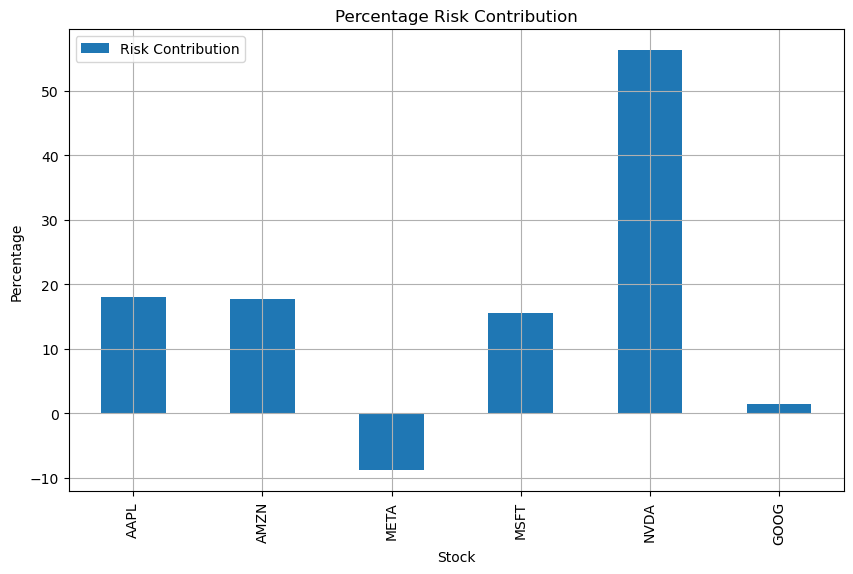

In [13]:
# Create Plot
plt.figure(figsize=(10, 6))
RC_percent.plot(kind='bar', label='Risk Contribution')

# Config
plt.title('Percentage Risk Contribution')
plt.xlabel('Stock')
plt.ylabel('Percentage')
plt.legend()
plt.grid()

# Show
plt.show() 

### Now Using Factor ###

In [14]:
# Now import the premiums
premiums_df = pd.read_csv(r'..\additional_data\famafrench_premiums.csv')
premiums_df.set_index('Date', inplace=True)
premiums_df.index = pd.to_datetime(premiums_df.index)
premiums_df.columns = ['mkt_premium', 'smb_premium', 'hml_premium', 'risk_free_rate']
premiums_df = premiums_df.div(100)

premiums_df

,mkt_premium,smb_premium,hml_premium,risk_free_rate
Date,,,,
2015-01-02,-0.0012,-0.0059,0.0012,0.00000
2015-01-05,-0.0184,0.0033,-0.0068,0.00000
2015-01-06,-0.0103,-0.0080,-0.0029,0.00000
2015-01-07,0.0119,0.0020,-0.0067,0.00000
2015-01-08,0.0181,-0.0012,-0.0029,0.00000
...,...,...,...,...
2025-03-25,0.0012,-0.0094,0.0005,0.00016
2025-03-26,-0.0122,-0.0048,0.0152,0.00016
2025-03-27,-0.0042,0.0019,0.0030,0.00016


In [15]:
# Now calculate the betas
portfolio_premium = portfolio_returns - premiums_df['risk_free_rate']

# Check if the Function Works
parameters = FamaFrenchFactors(
    portfolio_premium,
    premiums_df['mkt_premium'],
    premiums_df['smb_premium'],
    premiums_df['hml_premium'],
)

parameters

{'alpha': 0.0006317886617478294,
 'mkt_beta': 1.380451669625633,
 'smb_beta': -0.23745562281398613,
 'hml_beta': -0.6714191223332574}

In [16]:
# Create the Parameters Series
portfolio_parameters = pd.DataFrame([parameters])
portfolio_parameters.columns = ['const', 'mkt_premium', 'smb_premium', 'hml_premium']
portfolio_parameters = portfolio_parameters.T
portfolio_parameters.columns = ['parameters']
portfolio_parameters = portfolio_parameters['parameters']
portfolio_parameters = portfolio_parameters.iloc[1:]

portfolio_parameters

mkt_premium    1.380452
smb_premium   -0.237456
hml_premium   -0.671419
Name: parameters, dtype: float64

In [17]:
# Get the standard deviations of the premiums
premiums_std = premiums_df[['mkt_premium', 'smb_premium', 'hml_premium']].std()
premiums_std.name = 'premium_std'

premiums_std

mkt_premium    0.011491
smb_premium    0.006552
hml_premium    0.009020
Name: premium_std, dtype: float64

In [18]:
# Holding's correlations with the portfolio
factors_corr_with_portfolio = premiums_df[['mkt_premium', 'smb_premium', 'hml_premium']].corrwith(portfolio_returns)

factors_corr_with_portfolio

mkt_premium    0.795104
smb_premium    0.101011
hml_premium   -0.355209
dtype: float64

In [19]:
# Now obtain the x-sigma-rho
RC = portfolio_parameters * premiums_std * factors_corr_with_portfolio
RC.name = 'risk_contribution'

RC

mkt_premium    0.012612
smb_premium   -0.000157
hml_premium    0.002151
Name: risk_contribution, dtype: float64

In [20]:
# In percentage
RC_percent = (RC / np.sqrt(p_variance)) * 100

RC_percent

mkt_premium    63.570569
smb_premium    -0.792068
hml_premium    10.842613
Name: risk_contribution, dtype: float64

In [21]:
# Idiosyncratic Risk
idio_risk = 100 - RC_percent.sum()
idio_risk

26.378886238852758